# Example-01: Filter initialization & Matrix representation

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Initialize Filter instance

# Data instance should be passed as the first argument
# Filter class contains several static and class method, that can be used without passing Data instance

f = Filter(None)
print(f.data)

# make_matrix and make_signal functions can be used for matrix representation of a signal (Hankel matrix)
# Both functions act on a batch of signals and matrices, respectively

# Define test signal

signal = torch.linspace(1, 8, 8, dtype=dtype, device=device).unsqueeze(0)
print(signal.cpu().to(torch.int).numpy())

# Generate matrix representation

matrix = Filter.make_matrix(signal)
print(matrix.cpu().to(torch.int).numpy())

# Generate signal representation (average over skew diagonals)

print(Filter.make_signal(matrix).cpu().to(torch.int).numpy())

None
[[1 2 3 4 5 6 7 8]]
[[[1 2 3 4]
  [2 3 4 5]
  [3 4 5 6]
  [4 5 6 7]
  [5 6 7 8]]]
[[1 2 3 4 5 6 7 8]]


# Example-02: Singular values

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# svd_list and svd_list_randomized can be used to compute singular values
# svd_list performs full SVD and svd_list_randimized performs randomized SVD
# In both cases, requested number of largest singular values is returned

# Generate test signal (real signal with three harmonics)

length = 1024
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.sin(2*numpy.pi*0.12*time) + 0.1*torch.sin(2*numpy.pi*0.24*time) + 1.E-3*torch.sin(2*numpy.pi*0.31*time)
signal.unsqueeze_(0)

# Generate matrix representation

matrix = Filter.make_matrix(signal)

# Since, test signal contains three harmonics, it's matrix is expected to have six non-zero singular values

print(torch.linalg.matrix_rank(matrix))

# Compute singular values (full SVD)

S1 = Filter.svd_list(rank=6, matrix=matrix, cpu=True)

# svd_list used full SVD to compute singular values
# number of returned singular values is set by rank parameter
# input matrix should be a batch of matrices
# cpu flag is used to compute SVD using CPU

# Compute singular values (randomized SVD)

S2 = Filter.svd_list_randomized(rank=6, matrix=matrix, buffer=8, count=8, cpu=True)

# svd_list_randomized used randomized SVD to compute singular values
# randomized_range function is used to estimate matrix range with QR decomposition
# buffer parameter sets the number of extra dimensions, randomized range column rank is rank + buffer
# count parameter sets number of iterations

# Compare singular values

fmt = 3 * '{:<20.12}'
for s1, s2 in zip(S1.squeeze().cpu(), S2.squeeze().cpu()):
    print(fmt.format(s1, s2, abs(s1 - s2)))

tensor([6])
256.518221536       256.518221536       5.68434188608e-14   
255.980457668       255.980457668       2.84217094304e-14   
25.6585560702       25.6585560702       7.1054273576e-15    
25.5899723888       25.5899723888       1.06581410364e-14   
0.256513879015      0.256513879015      3.88578058619e-16   
0.255971936601      0.255971936601      1.66533453694e-16   


# Example-03: SVD truncation

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

tensor([4])
tensor([4])
256.656987075       256.656987075       0.0                 
256.119186377       256.119186377       0.0                 
25.642009985        25.642009985        2.13162820728e-14   
25.5735215174       25.5735215174       3.5527136788e-15    
2.6732280530085677e-13
4.652126792043313
4.65212679204333


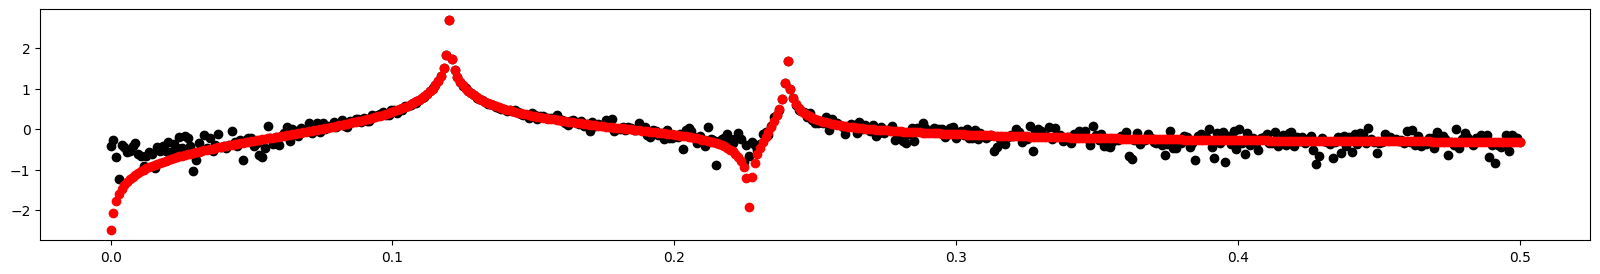

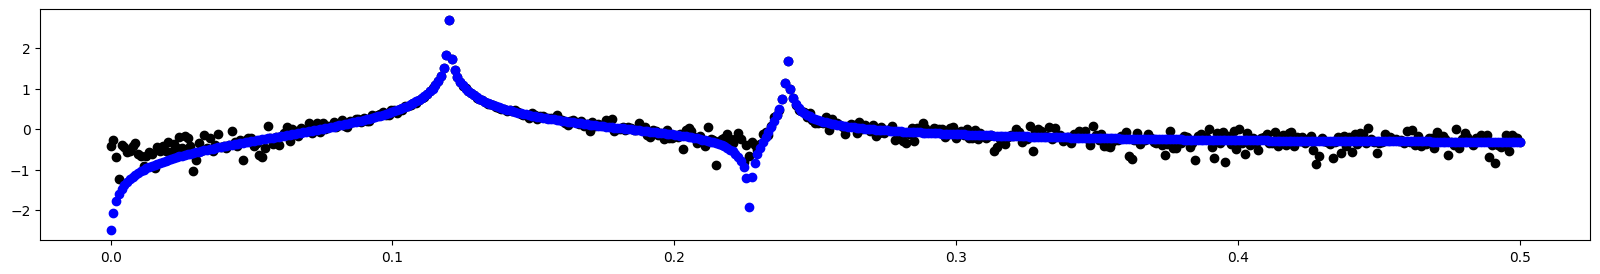

In [3]:
# svd_truncation and svd_truncation_randomized can be used to perform SVD truncation
# svd_truncation performs full SVD and svd_truncation_randomized performs randomized SVD
# In both cases, only the requested number of largest singular values are used to generated truncated matrix
# Truncated matrix is the best rank k approximation of the input
# These functions return list of singular values and truncated matrices

# Generate test signal (real signal with two harmonics and random noise)

length = 1024
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.sin(2*numpy.pi*0.12*time) + 0.1*torch.sin(2*numpy.pi*0.24*time)
sigma = 1.0E-2
signal.add_(sigma*torch.randn(length, dtype=dtype, device=device))
signal.unsqueeze_(0)

# Generate matrix representation

matrix = Filter.make_matrix(signal)

# Since noise is added, matrix is expected to have full rank

torch.linalg.matrix_rank(matrix)

# Perform SVD truncation (full SVD)

S1, M1 = Filter.svd_truncation(rank=4, matrix=matrix, cpu=True)
print(torch.linalg.matrix_rank(M1))

# Perform SVD truncation (randomized SVD)

S2, M2 = Filter.svd_truncation_randomized(rank=4, matrix=matrix, buffer=8, count=8, cpu=True)
print(torch.linalg.matrix_rank(M2))

# Compare singular values

fmt = 3 * '{:<20.12}'
for s1, s2 in zip(S1.squeeze().cpu(), S2.squeeze().cpu()):
    print(fmt.format(s1, s2, abs(s1 - s2)))
    
# Compare truncated matrices

print(torch.linalg.norm(M1 - M2).cpu().numpy())

# Estimate noise

print(100*abs(sigma-torch.std(matrix - M1).cpu().numpy())/sigma)
print(100*abs(sigma-torch.std(matrix - M2).cpu().numpy())/sigma)

# Convert to signal representation and DFT compare spectra

s1 = Filter.make_signal(M1).squeeze()
s2 = Filter.make_signal(M2).squeeze()
grid = torch.fft.rfftfreq(length, dtype=dtype)

plt.figure(figsize=(20, 3))
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(signal.squeeze()))).cpu(), c='black')
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(s1))).cpu(), c='red')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(signal.squeeze()))).cpu(), c='black')
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(s2))).cpu(), c='blue')
plt.show()

# Filtering potentialy allows to apply window function with less noise amplification
# Note, signals are assumed to have zero mean
# Remove mean before processing or increase number of requested singular values by one

# Example-04: Optimal SVD truncation, rank and noise estimation

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# estimate_noise function can be used for truncation rank and noise value estimation
# This function can be used when number of components in signal is not known

# Load test TbT data and add random noise

length = 1024

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.rand(54, dtype=dtype, device=device)
d.add_noise(s)
print(d)

# Filter instance

l = Filter(d)

# For estimation, only several first columns can ne used (32 by default)

R1, N1 = l.estimate_noise(limit=16, cpu=True)
R2, N2 = l.estimate_noise(limit=64, cpu=True)
R3, N3 = l.estimate_noise(limit=256, cpu=True)

# Estimate noise (average over samples)
# Generate several samples of length 256 from each signal using start shift 8

w = Window(256)
N4 = []
for i in range(54):
    l = Filter(Data.from_data(w, d.make_matrix(256, 8, d.work[i])))
    _, noise = l.estimate_noise(limit=64)
    N4.append(noise.mean().item())

Data(54, Window(1024, 'cosine_window', 1.0))


In [4]:
# Compare estimated ranks (note, expected rank is two)

fmt = 4 * '{:<6}'
print(fmt.format("", 16, 64, 256))
for i, (r1, r2, r3) in enumerate(zip(R1.cpu(), R2.cpu(), R3.cpu())):
    print(fmt.format(i, r1, r2, r3))
    
# Note, depending on particular noise parameters, results might be different
# In general, rank tends to be overestimated if large number of columns is used

      16    64    256   
0     2     2     2     
1     2     2     2     
2     2     2     2     
3     2     2     2     
4     2     2     2     
5     2     2     2     
6     2     2     4     
7     2     2     2     
8     2     2     2     
9     2     2     4     
10    2     2     6     
11    2     2     2     
12    2     2     2     
13    2     2     2     
14    2     2     2     
15    2     2     4     
16    2     2     2     
17    2     2     2     
18    2     2     2     
19    2     2     2     
20    2     2     2     
21    2     2     2     
22    2     2     4     
23    2     2     2     
24    2     2     2     
25    2     2     2     
26    2     2     4     
27    2     2     2     
28    2     2     2     
29    2     2     2     
30    2     2     2     
31    2     2     2     
32    2     2     2     
33    2     2     2     
34    2     2     2     
35    2     2     2     
36    2     2     2     
37    2     2     3     
38    2     2     2     


In [5]:
# Compare estimated noise

fmt = 5 * '{:<16}'
print(fmt.format("", 16, 64, 256, "ave"))
fmt = '{:<16}' + 4 * '{:<16.8}'
for i, (n0, n1, n2, n3, n4) in enumerate(zip(s.cpu(), N1.cpu(), N2.cpu(), N3.cpu(), N4)):
    print(fmt.format(i, 100*abs(n1-n0)/n0, 100*abs(n2-n0)/n0, 100*abs(n3-n0)/n0, 100*abs(n4-n0)/n0))
    
# Note, for noise sigma estimation, approximate expression is used
# In this example, noise estimation accuracy is better than 10%
# Using larger number of columns or averaging over samples do not affect estimation accuracy significantly (but better on average in both cases)

                16              64              256             ave             
0               0.47915342      0.087528867     2.1934142       0.71365566      
1               0.21271002      0.67294424      4.5367995       4.0219207       
2               3.7308667       3.5381534       3.3122365       1.5839669       
3               1.5410874       1.3820448       1.233048        0.89719118      
4               7.0971699       9.3571224       4.890757        4.5119573       
5               4.9144752       1.3800607       0.19875482      1.8737109       
6               6.3002811       4.7454327       2.741734        3.3772403       
7               4.0226756       3.3180798       5.9484788       2.0517828       
8               2.2580804       3.8625357       0.37736794      1.1753411       
9               4.5425113       4.9968058       0.1804213       3.3970867       
10              0.41171987      2.7105226       6.8927274       4.4698958       
11              0.61291344  

In [6]:
# Estimate noise using randomized SVD

l = Filter(d)
r1, s1 = l.estimate_noise(limit=32)
r2, s2 = l.estimate_noise(limit=512, randomized=True)

print((s1 - s).abs().max())
print((s2 - s).abs().max())

tensor(7.463131383647e-06, dtype=torch.float64)
tensor(8.629995807026e-06, dtype=torch.float64)


# Example-05: RPCA

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# https://arxiv.org/abs/0912.3599
# RPCA can be performed with rpca classmethod
# Single matrix should be passed on input (this can be a full TbT matrix or a Hankel matrix of a signal)

# Separate 'grained' noise using RPCA

# Generate original low rank matrix

n = 100
k = 3
m = 40
X = numpy.hstack([numpy.ones((n, m)) * (i + 1) * 10 for i in range(k)])
print(X.shape)
print(X)
print(torch.linalg.matrix_rank(torch.tensor(X)))

# Generate matrix with missing values (change fraction of missing values to observe convergence)

Y = numpy.copy(X)
Y[numpy.random.rand(*Y.shape) < 0.1] = 0.0
print(Y.shape)
print(Y)
print(torch.linalg.matrix_rank(torch.tensor(Y)))

# Perform RPCA (change the number of iterations and/or the tolerance factor to observe convergence)

count, error, L, S = Filter.rpca(torch.tensor(Y, dtype=dtype, device=device), limit=8912, factor=1.0E-12, cpu=True)

# Number of iterations and final error

print(count)
print(error)

# 'Cleaned' matrix rank

print(torch.linalg.matrix_rank(L))
print(L.cpu().numpy())

# Maximum element-wise error

print(numpy.max(numpy.abs((X - L.cpu().numpy()))))

(100, 120)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
tensor(1)
(100, 120)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ...  0. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
tensor(100)
296
tensor(1.527428311139e-09, dtype=torch.float64)
tensor(1)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
1.609272715086263e-10


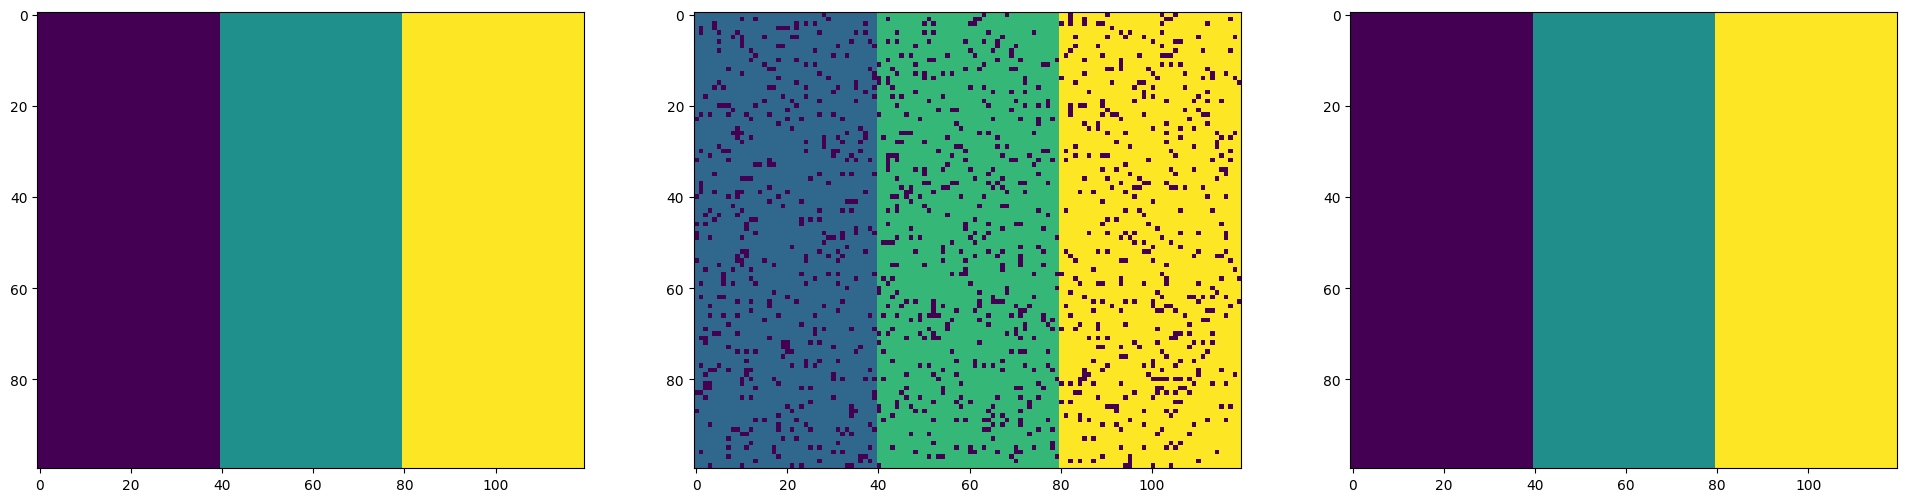

In [4]:
# Plot matrices

plt.figure(figsize=(3*8, 3*8))
ax = plt.subplot(331)
ax.imshow(X)
ax = plt.subplot(332)
ax.imshow(Y)
ax = plt.subplot(333)
ax.imshow(L)
plt.show()

# Example-06: TbT filtering (SVD & Hankel & RPCA)

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example frequency uncertanty is compared for different TbT filtering

In [4]:
# Compute reference frequency for test TbT data

# Load TbT

length = 4096

w = Window(length, 'cosine_window', 2.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy', dtype=dtype, device=device)

# Compute reference frequency

d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
d.reset()
ref = f.frequency.mean().cpu().item()
print(ref)

0.463116901262685


In [5]:
# Set parameters

length = 1024

# Set noise std for each BPM
# Note, each BPM has a different value of noise sigma

s = 1.0E-4*torch.rand(54, dtype=dtype, device=device)

# Test TbT data with random noise

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy', dtype=dtype, device=device)
d.add_noise(s)
d.data.copy_(d.work)

# Set filter instance

l = Filter(d)

# Set frequency instance

f = Frequency(d)

In [6]:
# Estimate noise (optimal SVD truncation)

_, n = l.estimate_noise(limit=64, cpu=True)

# Maximum noise estimation error

print(torch.max(100*torch.abs(n - s)/s).cpu().item())

9.636715942325775


In [7]:
# Compute frequencies without filtering

# Note, since error is random, i.e. deviation of mean from the reference
# The result should be judged mostly by frequency spread (assuming bias can be neglected)
# Depending on the noise level, windowing might (and in general does) increase spread

f = Frequency(d)

# Without window

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data without window')

# With window
# Note, in general, window will increase frequency spread, but reduce bias

d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data with window')

error: 1.16102183e-09   spread: 5.49676784e-07   case: raw data without window
error: 6.30374602e-08   spread: 8.9200318e-07    case: raw data with window


In [8]:
# Perform SVD filtering (full TbT)
# Note, filter modifies work container

d.reset()
l.filter_svd(rank=8, cpu=True)

# Compute frequencies with SVD filtering

# Without window
# Note, frequency spread is generaly reduced by SVD filtering

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD filtering without window')

# With window
# Note, filtering allows application of window without harmful effect on frequency spread
# In some cases frequency spread is further reduced

d.window_remove_mean()
d.window_apply()
f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD filtering with window')

error: 2.09490148e-08   spread: 3.27909693e-07   case: SVD filtering without window
error: 7.96122089e-08   spread: 5.58779644e-07   case: SVD filtering with window


In [9]:
# Perform Hankel filtering
# Note, when applied to raw TbT, Hankel filtering performs worse than SVD

d.reset()
l.filter_hankel(rank=8, cpu=True, random=True, buffer=8, count=8)

# Compute frequencies with Hankel filtering

# Without window
f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: Hankel filtering without window')

# With window
d.window_remove_mean()
d.window_apply()
f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: Hankel filtering with window')

error: 4.44044681e-08   spread: 7.32287939e-07   case: Hankel filtering without window
error: 4.9462552e-08    spread: 7.5850303e-07    case: Hankel filtering with window


In [10]:
# Perform SVD & Hankel filtering
# If Hankel filtering is applied after SVD, the frequency spread is further slightly reduced on average

d.reset()
l.filter_svd(rank=8, cpu=True)
l.filter_hankel(rank=8, cpu=True, random=True, buffer=8, count=8)

# Compute frequencies with Hankel filtering

# Without window

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD & Hankel filtering without window')

# With window

d.window_remove_mean()
d.window_apply()
f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD & Hankel filtering with window')

error: 4.18300841e-08   spread: 4.63847399e-07   case: SVD & Hankel filtering without window
error: 5.19099748e-08   spread: 4.56815949e-07   case: SVD & Hankel filtering with window


In [11]:
# Perform RPCA filtering
# Note, RPCA is not perfect for normal noise, large number of iterations is required in this case

d.reset()
l.filter_rpca(limit=2**10, factor=1.0E-15, cpu=True)

# Without window

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: RPCA filtering without window')

# With window

d.window_remove_mean()
d.window_apply()
f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: RPCA filtering with window')

error: 7.43332906e-08   spread: 3.34987187e-07   case: RPCA filtering without window
error: 2.26745318e-08   spread: 3.92151024e-07   case: RPCA filtering with window


# Example-07: Effect of filtering on parameter uncertainties

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Estimate frequency and amplitude uncertainty from multiple realizations

# Set parameters

length = 1024

# Set signal

t = torch.linspace(1, length, length, dtype=dtype, device=device)
s = 0.10
x = 1.0*torch.cos(2.0*numpy.pi*0.12345*t) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*t)

# Set TbT (signal copies with different noise realizations)

w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
d = torch.stack([x + s*torch.randn(length, dtype=dtype, device=device) for _ in range(256)])
d = Data.from_data(w, d)

# Estimate frequency

d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')
d.reset()

# Estimate amplitude

c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')
d.reset()

frequency: error=1.26410024892e-07, spread=3.81814912263e-06
amplitude: error=0.000512163724977, spread=0.0056016475787 


In [4]:
# Estimate rank/noise

l = Filter(d)
rank, noise = l.estimate_noise(limit=16, cpu=True)
print(f'min: {rank.min().cpu().item()}')
print(f'max: {rank.max().cpu().item()}')
print(f'std: {noise.mean().cpu().item()}')

min: 4
max: 4
std: 0.1026412609859475


In [5]:
# SVD

# Estimate frequency

l.filter_svd(rank=8, random=False, cpu=True)
d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')
d.reset()

# Estimate amplitude

l.filter_svd(rank=8, random=False, cpu=True)
c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')
d.reset()

frequency: error=1.25510749571e-07, spread=8.76861530316e-07
amplitude: error=0.000498240398673, spread=0.00457096556083


In [6]:
# SVD & Hankel

# Estimate frequency

l.filter_svd(rank=8, random=False, cpu=True)
l.filter_hankel(rank=8, random=True, buffer=8, count=8, cpu=True)
d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')
d.reset()

# Estimate amplitude

l.filter_svd(rank=8, random=False, cpu=True)
l.filter_hankel(rank=8, random=True, buffer=8, count=8, cpu=True)
c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')
d.reset()

frequency: error=8.56949437245e-08, spread=7.21431650161e-07
amplitude: error=0.000500307694795, spread=0.00452734702972


In [7]:
# RPCA

# Estimate frequency

l.filter_rpca(limit=4096, factor=1.0E-12, cpu=True)
d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')
d.reset()

# Estimate amplitude

l.filter_rpca(limit=4096, factor=1.E-12, cpu=True)
c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*t)*d.work*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')
d.reset()

frequency: error=2.58301275063e-07, spread=1.38231254689e-06
amplitude: error=0.00760342753129, spread=0.00506863357094


# Example-08: Mixed Hankel matrix

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

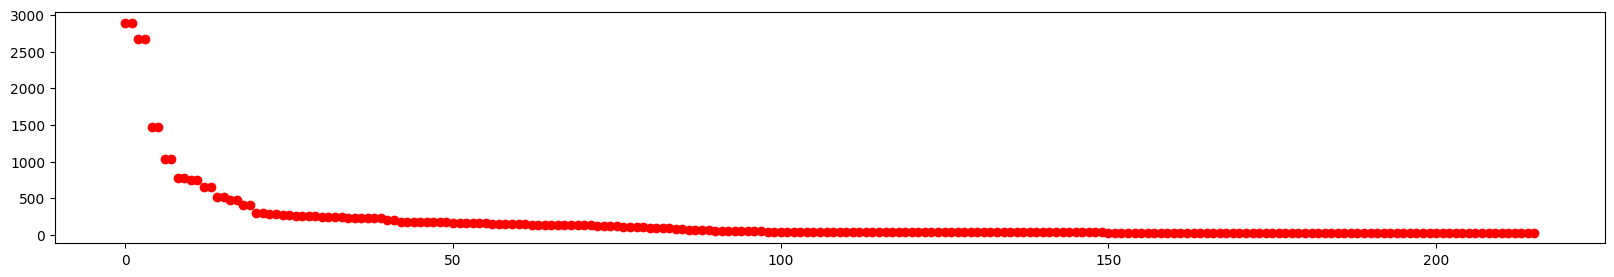

In [3]:
# Set parameters

length = 256

# Set noise std for each BPM

s = 1.0E-4*(4.0*torch.rand(54, dtype=dtype, device=device) + 1.0)

# Test TbT data with random noise

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(s)
d.window_remove_mean()
d.normalize()

# Mixed Hankel matrix

signal = d.make_signal(length, d.work)
matrix = d.make_matrix(8192, 1, signal)

# Compute singular values

out = Filter.svd_list_randomized(rank=4*54, matrix=torch.stack([matrix]), buffer=8, count=8, cpu=True).flatten()
plt.figure(figsize=(20, 3))
plt.scatter(range(4*54), out.cpu(), c='red')
plt.show()

In [4]:
# Optimal rank is expected to be close to 2*54

print(54*2)
print(Filter.svd_optimal(torch.stack([matrix])))

108
(tensor([116]), tensor([1.922685003252e-01], dtype=torch.float64))


# Example-09: Hankel matrix singular values approximation

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

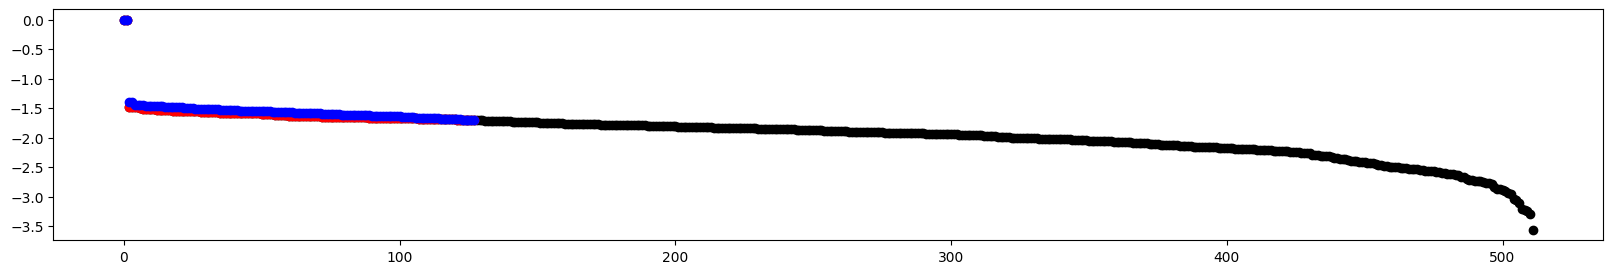

In [3]:
# Set parameters

length = 1024

# Set noise std for each BPM

s = 1.0E-4*(4.0*torch.rand(54, dtype=dtype, device=device) + 1.0)

# Test TbT data with random noise

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(s)
d.window_remove_mean()
d.normalize()

# Hankel matrix

matrix, *_ = Filter.make_matrix(d.work)

# Compute all singular values with full SVD

s1 = Filter.svd_list(min(matrix.shape), torch.stack([matrix]))
s1, *_ = s1/s1.max()

# Compute first 128 singular values with randomized SVD

s2 = Filter.svd_list_randomized(128, torch.stack([matrix]), buffer=16, count=16)
s2, *_ = s2/s2.max()

# Compute 128 singular values with full SVD using first 256 columns

s3 = Filter.svd_list(128, torch.stack([matrix[:, :256]]))
s3, *_ = s3/s3.max()

# Compare singular values

plt.figure(figsize=(20, 3))
plt.scatter(range(len(s1)), s1.log10_().cpu(), color='black')
plt.scatter(range(len(s2)), s2.log10_().cpu(), color='red')
plt.scatter(range(len(s3)), s3.log10_().cpu(), color='blue')
plt.show()

# Example-10: ICA filtering

In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.util import data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Compute reference frequency for test TbT data

# Load TbT

length = 4096

w = Window(length, 'cosine_window', 2.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy', dtype=dtype, device=device)

# Compute reference frequency

d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
d.reset()
ref = f.frequency.mean().cpu().item()
print(ref)

0.463116901262685


In [4]:
# Set parameters

length = 1024

# Set noise std for each BPM
# Note, each BPM has a different value of noise sigma

s = 1.0E-4*torch.rand(54, dtype=dtype, device=device)

# Test TbT data with random noise

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy', dtype=dtype, device=device)
d.add_noise(s)
d.data.copy_(d.work)

# Set filter instance

l = Filter(d)

# Set frequency instance

f = Frequency(d)

In [5]:
# Estimate noise (optimal SVD truncation)

_, n = l.estimate_noise(limit=64, cpu=True)

# Maximum noise estimation error

print(torch.max(100*torch.abs(n - s)/s).cpu().item())

10.47386737532945


In [6]:
# Compute frequencies without filtering

# Note, since error is random, i.e. deviation of mean from the reference
# The result should be judged mostly by frequency spread (assuming bias can be neglected)
# Depending on the noise level, windowing might (and in general does) increase spread

f = Frequency(d)

# Without window

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data without window')

# With window
# Note, in general, window will increase frequency spread, but reduce bias

d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data with window')

error: 4.01550894e-08   spread: 6.96058661e-07   case: raw data without window
error: 6.33054142e-09   spread: 8.36988268e-07   case: raw data with window


In [7]:
# Perform ICA filtering

from sklearn.decomposition import FastICA


ica = FastICA(n_components=4, max_iter=10000, tol=1.0E-6, whiten='unit-variance')
fit = torch.tensor(ica.fit_transform(d.data.T.cpu().numpy()), dtype=dtype, device=device)
mix = torch.tensor(ica.mixing_, dtype=dtype, device=device)
tbt = Data.from_data(w, mix @ fit.T)

f = Frequency(tbt)

# Without window

f('parabola')
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9}')

# With window
# Note, in general, window will increase frequency spread, but reduce bias

tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9}')

error: 1.09720636e-07   spread: 4.56327957e-07  
error: 1.09525459e-07   spread: 3.4072578e-07   
